In [2]:
!pip install linearmodels  

In [3]:
import os  
import pandas as pd  
import requests  
import zipfile  
import geopandas as gpd  
import matplotlib.pyplot as plt  
from shapely.geometry import Point  
from functools import reduce  

import seaborn as sns  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.preprocessing import StandardScaler  
import numpy as np  

Zip file already exists. Skipping download.
Found existing shapefile at: data/London-wards-2014/London-wards-2014 (1)/London-wards-2014_ESRI/London_Ward.shp
Shapefile already extracted at: data/London-wards-2014/London-wards-2014 (1)/London-wards-2014_ESRI/London_Ward.shp
Loading the shapefile...
                     NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0       Chessington South  E05000405   755.173         0.0  E09000021   
1  Tolworth and Hook Rise  E05000414   259.464         0.0  E09000021   
2              Berrylands  E05000401   145.390         0.0  E09000021   
3               Alexandra  E05000400   268.506         0.0  E09000021   
4                Beverley  E05000402   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            ge

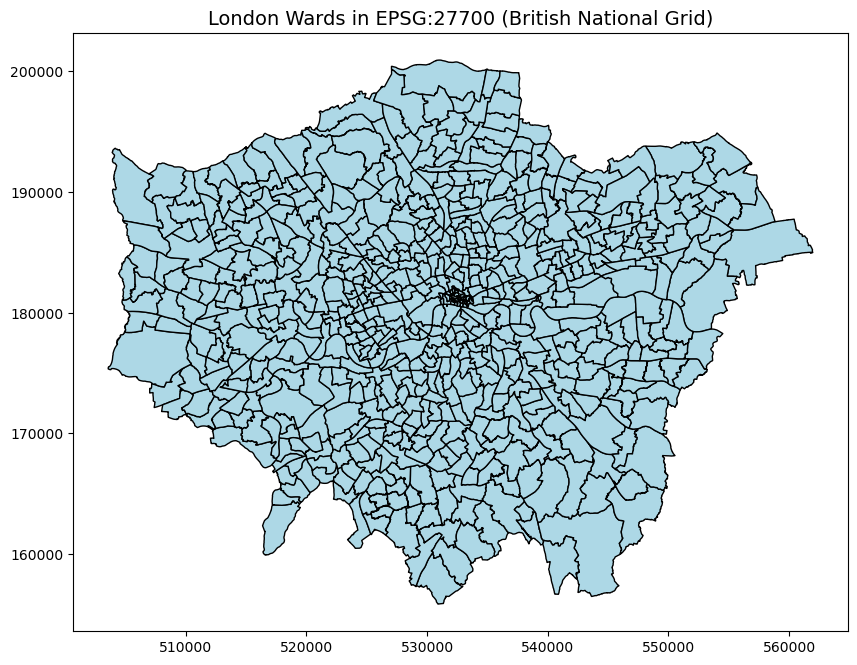

In [4]:
# Settings  
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/b381c92b-9120-45c6-b97e-0f7adc567dd2/London-wards-2014.zip"  
zip_path = "data/London-wards-2014.zip"  
extract_dir = "data/London-wards-2014"  

os.makedirs("data", exist_ok=True)  

# Download ZIP if necessary  
if not os.path.exists(zip_path):  
    print("Downloading zip file…")  
    resp = requests.get(url)  
    with open(zip_path, "wb") as f:  
        f.write(resp.content)  
else:  
    print("Zip file already exists. Skipping download.")  

# Extract ZIP if shapefile not already present  
need_extract = True  
if os.path.exists(extract_dir):  
    # Search for .shp file recursively  
    for root, dirs, files in os.walk(extract_dir):  
        for f in files:  
            if f.lower() == "london_ward.shp":  
                shp_path = os.path.join(root, f)  
                need_extract = False  
                print(f"Found existing shapefile at: {shp_path}")  
                break  
        if not need_extract:  
            break  

if need_extract:  
    print("Extracting zip file…")  
    with zipfile.ZipFile(zip_path, "r") as zip_ref:  
        zip_ref.extractall(extract_dir)  
    # Find .shp after extraction  
    shp_path = None  
    for root, dirs, files in os.walk(extract_dir):  
        for f in files:  
            if f.lower() == "london_ward.shp":  
                shp_path = os.path.join(root, f)  
                print(f"Shapefile extracted at: {shp_path}")  
                break  
        if shp_path:  
            break  
    if not shp_path:  
        raise FileNotFoundError("Shapefile not found after extraction!")  
else:  
    print(f"Shapefile already extracted at: {shp_path}")  

# Load shapefile with geopandas  
print("Loading the shapefile...")  
wards = gpd.read_file(shp_path)  
print(wards.head())  

# Plot  
wards = wards.to_crs(epsg=27700)  
fig, ax = plt.subplots(figsize=(10, 10))  
wards.plot(ax=ax, color="lightblue", edgecolor="black")  
ax.set_title("London Wards in EPSG:27700 (British National Grid)", fontsize=14)  
plt.show()   

### Loading the data

/tmp/ipykernel_3368/3222630787.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  facilities = pd.read_csv('data/GIS_Active_Places_Power_Facility_2339094778124018571.csv')
/tmp/ipykernel_3368/3222630787.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  facilities['closed_date'] = pd.to_datetime(facilities['closed_date'], errors='coerce')


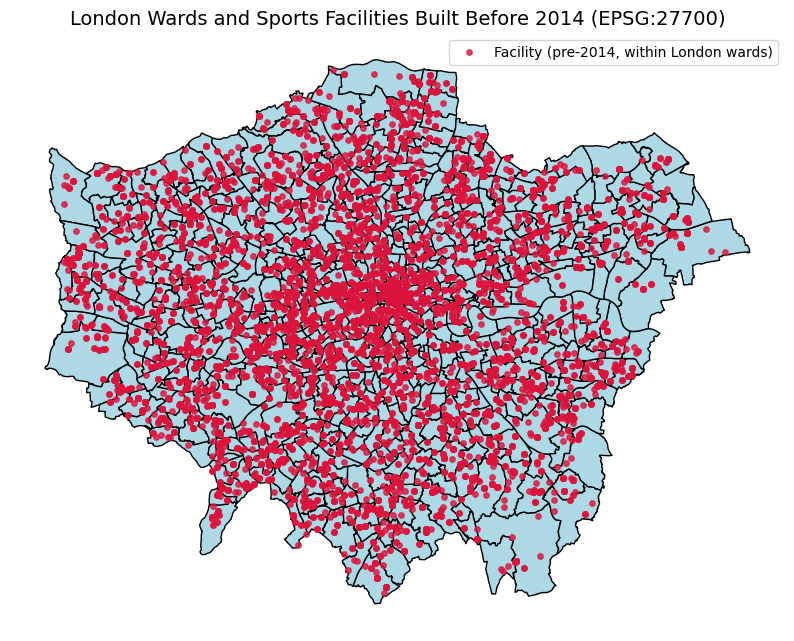

In [5]:
# Read and rename columns for clarity  
facilities = pd.read_csv('data/GIS_Active_Places_Power_Facility_2339094778124018571.csv')  
facilities = facilities.rename(columns={  
    'Accessibility Type Group (Text)': 'access_group',  
    'Management Type Group (Text)': 'mgmt_group',  
    'Facility Type': 'facility_type',  
    'Year Built': 'year_built',  
    'Closed Date': 'closed_date',  
    'Latitude': 'lat',  
    'Longitude': 'lon'  
})  

# Select relevant columns  
facilities = facilities[['lat', 'lon', 'year_built', 'access_group', 'mgmt_group', 'facility_type', 'closed_date']]  

# Type conversion for filtering  
facilities['year_built'] = pd.to_numeric(facilities['year_built'], errors='coerce')  
facilities['closed_date'] = pd.to_datetime(facilities['closed_date'], errors='coerce')  

# Filter: built before 2014 and (not closed or closed in/after 2014)  
mask = (facilities['year_built'] < 2014) & (  
    facilities['closed_date'].isna() | (facilities['closed_date'].dt.year >= 2014)  
)  
facilities = facilities[mask]  

# Convert to GeoDataFrame (WGS84)  
geometry = [Point(xy) for xy in zip(facilities['lon'], facilities['lat'])]  
gdf_fac = gpd.GeoDataFrame(facilities, geometry=geometry, crs="EPSG:4326")  

# Reproject to EPSG:27700 to match wards  
gdf_fac = gdf_fac.to_crs(epsg=27700)  

# Clip facility points to London wards boundary (keep only points within wards)  
gdf_fac_london = gpd.sjoin(gdf_fac, wards, predicate='within', how='inner')  

# Plot: overlay points on wards map  
fig, ax = plt.subplots(figsize=(10, 10))  
wards.plot(ax=ax, color="lightblue", edgecolor="black")  
gdf_fac_london.plot(  
    ax=ax, color="crimson", markersize=15, label="Facility (pre-2014, within London wards)", alpha=0.8  
)  
ax.set_title("London Wards and Sports Facilities Built Before 2014 (EPSG:27700)", fontsize=14)  
ax.axis('off')  
plt.legend()  
plt.show()  

In [6]:
years = range(2010, 2015)  
pop_years = [2011, 2012, 2013, 2014]  
facility_types = ['Education', 'Commercial', 'Local Authority']  # 可按实际表格类型增减  

ward_cols = ['NAME', 'GSS_CODE',  'BOROUGH', 'geometry']  
wards_fac_count = wards[ward_cols].copy()  

# ---- Step 1: Count active facilities per ward per year and by mgmt_group ----  
for yr in years:  
    # Only keep facilities open in the given year  
    mask_active = (  
        (gdf_fac_london['year_built'] <= yr) &  
        (gdf_fac_london['closed_date'].isna() | (gdf_fac_london['closed_date'].dt.year >= yr))  
    )  
    active = gdf_fac_london[mask_active]  

    # Group and count each facility type separately  
    for ftype in facility_types:  
        temp = active[active['mgmt_group'] == ftype]  
        by_ward = temp.groupby('GSS_CODE').size().rename(f'facility_{ftype.lower()}_{yr}').reset_index()  
        wards_fac_count = wards_fac_count.merge(by_ward, on='GSS_CODE', how='left')  
    # Optional: Also count total facilities for each year if you need it  
    # by_ward_total = active.groupby('GSS_CODE').size().rename(f'facility_total_{yr}').reset_index()  
    # wards_fac_count = wards_fac_count.merge(by_ward_total, on='GSS_CODE', how='left')  

# Fill missing with 0  
for ftype in facility_types:  
    for yr in years:  
        col = f'facility_{ftype.lower()}_{yr}'  
        if col in wards_fac_count.columns:  
            wards_fac_count[col] = wards_fac_count[col].fillna(0)  

# ---- Step 2: Read and prepare population data for each year (2011-2014) ----  
pop_files = [  
    'data/London_Population_wards/mid_2011_ward_2011_quinary.csv',  
    'data/London_Population_wards/SAPE20DT8-mid-2012-ward-2017-syoa-estimates-unformatted.csv',  
    'data/London_Population_wards/SAPE20DT8-mid-2013-ward-2017-syoa-estimates-unformatted.csv',  
    'data/London_Population_wards/SAPE20DT8-mid-2014-ward-2017-syoa-estimates-unformatted.csv'  
]  

pop_dfs = []  
for file, year in zip(pop_files, pop_years):  
    df = pd.read_csv(file, low_memory=False)  
    col_map = {'Ward Code': 'GSS_CODE', 'All Ages': f'pop_{year}'}  
    df = df[list(col_map.keys())].rename(columns=col_map)  
    df[f'pop_{year}'] = pd.to_numeric(df[f'pop_{year}'].astype(str).str.replace(',', ''), errors='coerce')  
    pop_dfs.append(df)  
df_pop = reduce(lambda left, right: pd.merge(left, right, on='GSS_CODE', how='outer'), pop_dfs)  

# ---- Step 3: Merge population into wards/facilities table ----  
wards_fac_pop = wards_fac_count.merge(df_pop, on='GSS_CODE', how='left')  

# ---- Step 4: Calculate per 10,000 population facility rate for each type and year ----  
for idx, yr in enumerate(pop_years):  
    for ftype in facility_types:  
        fac_col = f'facility_{ftype.lower()}_{yr}'  
        wards_fac_pop[f'facility_{ftype.lower()}_per_10000pop_{yr}'] = (  
            wards_fac_pop[fac_col] / wards_fac_pop[f'pop_{yr}'] * 10000  
        )  

# ---- Step 5: Only keep per 10,000 columns + ward info, remove raw counts & pop ----  
to_keep = ward_cols.copy()  
for yr in pop_years:  
    for ftype in facility_types:  
        to_keep.append(f'facility_{ftype.lower()}_per_10000pop_{yr}')  
wards_fac_pop = wards_fac_pop[to_keep]  

# ---- Step 6: Display preview ----  
print(wards_fac_pop.head())  

                     NAME   GSS_CODE               BOROUGH  \
0       Chessington South  E05000405  Kingston upon Thames   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames   
2              Berrylands  E05000401  Kingston upon Thames   
3               Alexandra  E05000400  Kingston upon Thames   
4                Beverley  E05000402  Kingston upon Thames   

                                            geometry  \
0  POLYGON ((516401.6 160201.8, 516407.3 160210.5...   
1  POLYGON ((517829.6 165447.1, 517837.1 165469.4...   
2  POLYGON ((518107.5 167303.4, 518114.3 167307.5...   
3  POLYGON ((520480 166909.8, 520490.7 166901.9, ...   
4  POLYGON ((522071 168144.9, 522063.9 168144, 52...   

   facility_education_per_10000pop_2011  \
0                              3.903963   
1                              4.061738   
2                              0.000000   
3                              8.636511   
4                              0.000000   

   facility_commercial_per_1000

In [7]:
# 1. Read childhood obesity CSV, skipping first 2 rows
df_obesity = pd.read_csv('data/Childhood_obesity_2008-09_2013-14.csv', skiprows=2)  

# 2. Clean and clarify column names for age and survey period  
rename_dict = {  
    'New Code': 'GSS_CODE',  
    'Borough': 'BOROUGH',  
    'Names': 'NAME',  
    # Reception (age 4-5)  
    '2008/09 to 2010/11: % obese':  'obese_recp_2008_2011',  
    '2009/10 to 2011/12: % obese':  'obese_recp_2009_2012',  
    '2010/11 to 2012/13: % obese':  'obese_recp_2010_2013',  
    '2011/12 to 2013/14: % obese':  'obese_recp_2011_2014',  
    # Year 6 (age 10-11)  
    '2008/09 to 2010/11: % obese.1': 'obese_y6_2008_2011',  
    '2009/10 to 2011/12: % obese.1': 'obese_y6_2009_2012',  
    '2010/11 to 2012/13: % obese.1': 'obese_y6_2010_2013',  
    '2011/12 to 2013/14: % obese.1': 'obese_y6_2011_2014',  
}  
df_obesity = df_obesity.rename(columns=rename_dict)  

# 3. Only keep relevant columns  
keep_cols = ['GSS_CODE', 'BOROUGH', 'NAME',  
             'obese_recp_2008_2011', 'obese_recp_2009_2012',   
             'obese_recp_2010_2013', 'obese_recp_2011_2014',  
             'obese_y6_2008_2011', 'obese_y6_2009_2012',  
             'obese_y6_2010_2013', 'obese_y6_2011_2014']  
df_obesity = df_obesity[keep_cols]  

# 4. Convert percentage columns to numeric (handles 'n/a' as NaN)  
for col in keep_cols[3:]:  
    df_obesity[col] = pd.to_numeric(df_obesity[col], errors='coerce')  

# 5. Choose target columns from main (facility/population) DataFrame  
final_fac_cols = [  
    'NAME', 'GSS_CODE', 'BOROUGH', 'geometry',  
    'facility_education_per_10000pop_2011', 'facility_education_per_10000pop_2012',  
    'facility_education_per_10000pop_2013', 'facility_education_per_10000pop_2014',  
    'facility_commercial_per_10000pop_2011', 'facility_commercial_per_10000pop_2012',  
    'facility_commercial_per_10000pop_2013', 'facility_commercial_per_10000pop_2014',  
    'facility_local authority_per_10000pop_2011', 'facility_local authority_per_10000pop_2012',  
    'facility_local authority_per_10000pop_2013', 'facility_local authority_per_10000pop_2014'  
]  
# 6. Merge with main DataFrame to create a master table  
wards_master_df = wards_fac_pop[final_fac_cols].merge(  
    df_obesity, on=['GSS_CODE', 'BOROUGH', 'NAME'], how='left'  
)  

# 7. Preview the output  
print(wards_master_df.head())  


                     NAME   GSS_CODE               BOROUGH  \
0       Chessington South  E05000405  Kingston upon Thames   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames   
2              Berrylands  E05000401  Kingston upon Thames   
3               Alexandra  E05000400  Kingston upon Thames   
4                Beverley  E05000402  Kingston upon Thames   

                                            geometry  \
0  POLYGON ((516401.6 160201.8, 516407.3 160210.5...   
1  POLYGON ((517829.6 165447.1, 517837.1 165469.4...   
2  POLYGON ((518107.5 167303.4, 518114.3 167307.5...   
3  POLYGON ((520480 166909.8, 520490.7 166901.9, ...   
4  POLYGON ((522071 168144.9, 522063.9 168144, 52...   

   facility_education_per_10000pop_2011  facility_education_per_10000pop_2012  \
0                              3.903963                              4.795243   
1                              4.061738                              4.054328   
2                              0.000000        

In [8]:
# Step 1: Read and clean unemployment (out-of-work family) data  
unemp = pd.read_csv("data/out-of-work-family-2010_2014.csv", skiprows=1, usecols=[  
    "New Code", "2010", "2011", "2012", "2013", "2014"  
])  
unemp = unemp.rename(columns={  
    "New Code": "GSS_CODE",  
    "2010": "unemp_2010",  
    "2011": "unemp_2011",  
    "2012": "unemp_2012",  
    "2013": "unemp_2013",  
    "2014": "unemp_2014"  
})  
for col in [f"unemp_{y}" for y in range(2010, 2015)]:  
    unemp[col] = pd.to_numeric(unemp[col], errors='coerce')  

# Step 2: Read green space and PTAL, using column positions  
df_green_ptal = pd.read_csv("data/wards_greenspace_2010_2014.csv", skiprows=1)  

# greenspace columns (pure years, first block after names)  
greenspace_cols = ["New Code", "2012", "2014"]  
df_green = df_green_ptal[greenspace_cols].rename(columns={  
    "New Code": "GSS_CODE",  
    "2012": "greenspace_pct_2012",  
    "2014": "greenspace_pct_2014"  
})  

for col in ["greenspace_pct_2012", "greenspace_pct_2014"]:  
    df_green[col] = pd.to_numeric(df_green[col], errors='coerce')  

# PTAL columns: (next block of four years, after greenspace columns)  
# Find the position (index) of the first '2012' column, then next four cols for PTAL  
all_cols = list(df_green_ptal.columns)  
idx_first_2012 = all_cols.index("2012")  
ptal_years = [col for col in all_cols[idx_first_2012+2:idx_first_2012+6]] # usually J: 2010, K: 2011, L:2012, M:2014  
ptal_cols = ["New Code"] + ptal_years  
df_ptal = df_green_ptal[ptal_cols].rename(columns={  
    "New Code": "GSS_CODE",  
    ptal_years[0]: "ptal_2010",  
    ptal_years[1]: "ptal_2011",  
    ptal_years[2]: "ptal_2012",  
    ptal_years[3]: "ptal_2014"  
})  

for col in ["ptal_2010", "ptal_2011", "ptal_2012", "ptal_2014"]:  
    df_ptal[col] = pd.to_numeric(df_ptal[col], errors="coerce")  

# Step 3: Interpolate missing years with linear interpolation  
df_green["greenspace_pct_2011"] = df_green["greenspace_pct_2012"]  # carry backward  
df_green["greenspace_pct_2013"] = (df_green["greenspace_pct_2012"] + df_green["greenspace_pct_2014"]) / 2  

df_ptal["ptal_2013"] = (df_ptal["ptal_2012"] + df_ptal["ptal_2014"]) / 2  

# Step 4: Merge into the master ward DataFrame  
wards_master_df = wards_master_df.merge(unemp, on="GSS_CODE", how="left")  
wards_master_df = wards_master_df.merge(df_green[["GSS_CODE",  
                                                  "greenspace_pct_2011", "greenspace_pct_2012", "greenspace_pct_2013", "greenspace_pct_2014"]],  
                                        on="GSS_CODE", how="left")  
wards_master_df = wards_master_df.merge(df_ptal[["GSS_CODE",  
                                                 "ptal_2010", "ptal_2011", "ptal_2012", "ptal_2013", "ptal_2014"]],  
                                        on="GSS_CODE", how="left")  

# Step 5: Preview merged result  
print(wards_master_df.info())  

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 38 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   NAME                                        654 non-null    object  
 1   GSS_CODE                                    654 non-null    object  
 2   BOROUGH                                     654 non-null    object  
 3   geometry                                    654 non-null    geometry
 4   facility_education_per_10000pop_2011        570 non-null    float64 
 5   facility_education_per_10000pop_2012        637 non-null    float64 
 6   facility_education_per_10000pop_2013        637 non-null    float64 
 7   facility_education_per_10000pop_2014        637 non-null    float64 
 8   facility_commercial_per_10000pop_2011       570 non-null    float64 
 9   facility_commercial_per_10000pop_2012       637 non-null    float64 

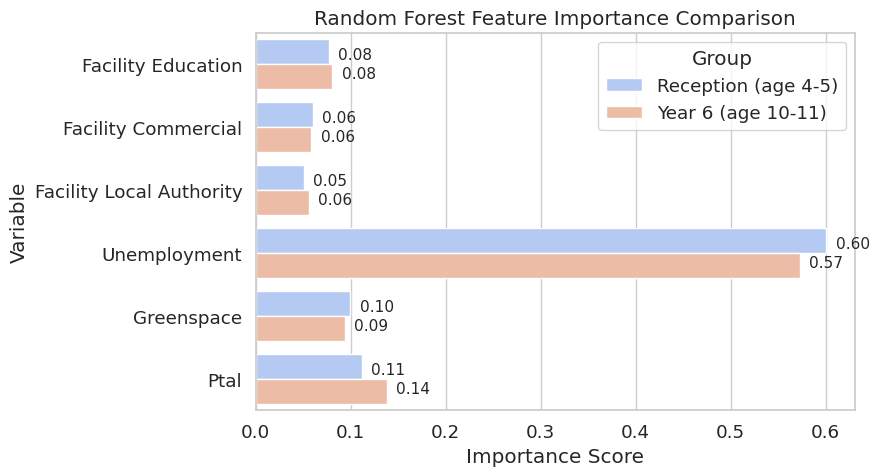

In [9]:
sns.set_theme(style="whitegrid", font_scale=1.2)  

years = [2011, 2012, 2013, 2014]  
groups = {  
    'Reception': [f'obese_recp_{y-3}_{y}' for y in years],  
    'Year6': [f'obese_y6_{y-3}_{y}' for y in years]  
}  
panel_vars = [  
    # Education  
    'facility_education_per_10000pop_2011', 'facility_education_per_10000pop_2012',   
    'facility_education_per_10000pop_2013', 'facility_education_per_10000pop_2014',  
    # Commercial  
    'facility_commercial_per_10000pop_2011', 'facility_commercial_per_10000pop_2012',  
    'facility_commercial_per_10000pop_2013', 'facility_commercial_per_10000pop_2014',  
    # Local Authority  
    'facility_local authority_per_10000pop_2011', 'facility_local authority_per_10000pop_2012',  
    'facility_local authority_per_10000pop_2013', 'facility_local authority_per_10000pop_2014',  
    # Controls  
    'unemp_2011', 'unemp_2012', 'unemp_2013', 'unemp_2014',  
    'greenspace_pct_2011', 'greenspace_pct_2012', 'greenspace_pct_2013', 'greenspace_pct_2014',  
    'ptal_2011', 'ptal_2012', 'ptal_2013', 'ptal_2014'  
]  

# Store importance for both groups  
importances_dict = {}  

for group_name, obs_columns in groups.items():  
    ml_df = wards_master_df[['GSS_CODE', 'NAME', 'BOROUGH'] + panel_vars + obs_columns].copy()  
    ml_panel = pd.DataFrame()  
    for i, tgt in enumerate(obs_columns):  
        yr = years[i]  
        row = ml_df[[  
            'GSS_CODE', 'NAME', 'BOROUGH',  
            f'facility_education_per_10000pop_{yr}',  
            f'facility_commercial_per_10000pop_{yr}',  
            f'facility_local authority_per_10000pop_{yr}',  
            f'unemp_{yr}',  
            f'greenspace_pct_{yr}',  
            f'ptal_{yr}',  
            tgt  
        ]].copy()  
        row = row.rename(columns={  
            f'facility_education_per_10000pop_{yr}': 'facility_education',  
            f'facility_commercial_per_10000pop_{yr}': 'facility_commercial',  
            f'facility_local authority_per_10000pop_{yr}': 'facility_local_authority',  
            f'unemp_{yr}': 'unemployment',  
            f'greenspace_pct_{yr}': 'greenspace',  
            f'ptal_{yr}': 'ptal',  
            tgt: 'obesity'  
        })  
        row['year'] = yr  
        ml_panel = pd.concat([ml_panel, row], axis=0)  

    X = ml_panel[['facility_education', 'facility_commercial', 'facility_local_authority', 'unemployment', 'greenspace', 'ptal']]  
    y = ml_panel['obesity']  
    mask = (~X.isnull().any(axis=1)) & (~y.isnull())  
    X = X[mask]  
    y = y[mask]  

    scaler = StandardScaler()  
    X_scaled = scaler.fit_transform(X)  
    rf = RandomForestRegressor(n_estimators=200, random_state=42)  
    rf.fit(X_scaled, y)  
    importances_dict[group_name] = rf.feature_importances_  

feature_names = [  
    'Facility Education', 'Facility Commercial', 'Facility Local Authority',  
    'Unemployment', 'Greenspace', 'Ptal'  
]  

# Rename keys for age group clarity  
rename_map = {  
    'Reception': 'Reception (age 4-5)',  
    'Year6': 'Year 6 (age 10-11)'  
}  
df_imp = pd.DataFrame({  
    'Variable': feature_names,  
    'Reception (age 4-5)': importances_dict['Reception'],  
    'Year 6 (age 10-11)': importances_dict['Year6']  
})  

df_imp_melt = df_imp.melt(id_vars='Variable', var_name='Group', value_name='Importance')  

plt.figure(figsize=(9,5))  
sns.barplot(  
    data=df_imp_melt,  
    x='Importance',  
    y='Variable',  
    hue='Group',  
    palette='coolwarm',  
    orient='h'  
)  
plt.title("Random Forest Feature Importance Comparison")  
plt.xlabel("Importance Score")  
plt.ylabel("Variable")  
plt.legend(title="Group")  
for i in range(df_imp.shape[0]):  
    for j, group in enumerate(['Reception (age 4-5)', 'Year 6 (age 10-11)']):  
        val = df_imp.loc[i, group]  
        plt.text(val+0.01, i-0.15+j*0.3, f"{val:.2f}", va='center', fontsize=11)  
plt.tight_layout()  
plt.show()  

# VIF Test

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  

X_vif = ml_panel[['facility_education', 'facility_commercial', 'facility_local_authority', 'unemployment', 'greenspace', 'ptal']]  
X_vif = X_vif.dropna().values  # Drop NA for VIF  

vif_df = pd.DataFrame()  
vif_df["Variable"] = ['facility_education', 'facility_commercial', 'facility_local_authority', 'unemployment', 'greenspace', 'ptal']  
vif_df["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]  

print(vif_df)  

                   Variable       VIF
0        facility_education  2.053283
1       facility_commercial  1.585117
2  facility_local_authority  1.447403
3              unemployment  3.502285
4                greenspace  3.299106
5                      ptal  4.137845


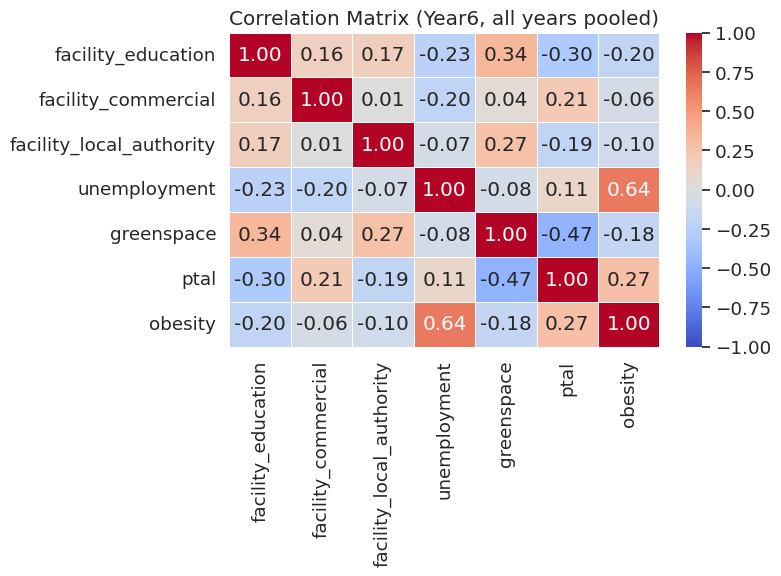

In [11]:
# Only keep numeric variables for the correlation matrix (incl. obesity as label)  
corr_vars = ['facility_education', 'facility_commercial', 'facility_local_authority',  
                 'unemployment', 'greenspace', 'ptal', 'obesity']  
corr_df = ml_panel[corr_vars].dropna()  
corr_matrix = corr_df.corr()  

# Plot heatmap  
plt.figure(figsize=(8,6))  
sns.heatmap(  
    corr_matrix,  
    annot=True,  
    fmt=".2f",  
    cmap='coolwarm',  
    vmin=-1, vmax=1,  
    linewidths=0.5,  
    cbar=True  
)  
plt.title(f'Correlation Matrix ({group_name}, all years pooled)')  
plt.tight_layout()  
plt.show()  

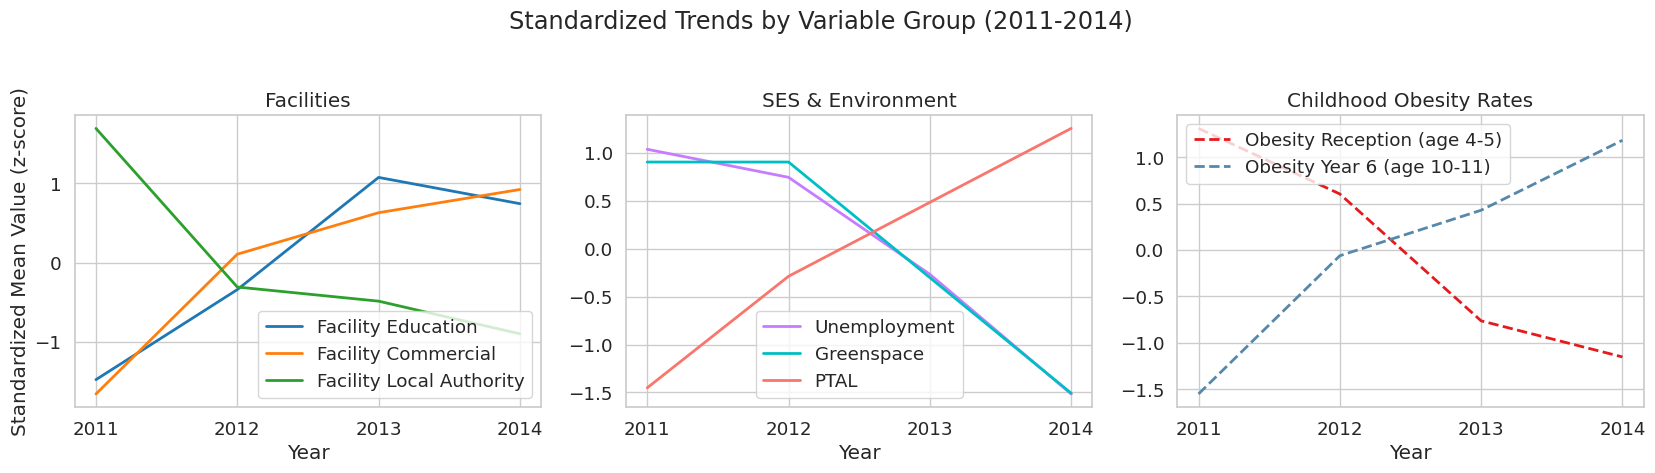

In [12]:
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.preprocessing import StandardScaler  
import pandas as pd  

# ---- Data prep ----  
years = [2011, 2012, 2013, 2014]  
obese_recp_vars = [  
    'obese_recp_2008_2011', 'obese_recp_2009_2012',  
    'obese_recp_2010_2013', 'obese_recp_2011_2014'  
]  
obese_y6_vars = [  
    'obese_y6_2008_2011', 'obese_y6_2009_2012',  
    'obese_y6_2010_2013', 'obese_y6_2011_2014'  
]  
facility_edu_vars = [f'facility_education_per_10000pop_{y}' for y in years]  
facility_com_vars = [f'facility_commercial_per_10000pop_{y}' for y in years]  
facility_local_vars = [f'facility_local authority_per_10000pop_{y}' for y in years]  
unemp_vars = [f'unemp_{y}' for y in years]  
greenspace_vars = [f'greenspace_pct_{y}' for y in years]  
ptal_vars = [f'ptal_{y}' for y in years]  

trend_df = pd.DataFrame({  
    'Year': years,  
    'Facility Education': [wards_master_df[v].mean() for v in facility_edu_vars],  
    'Facility Commercial': [wards_master_df[v].mean() for v in facility_com_vars],  
    'Facility Local Authority': [wards_master_df[v].mean() for v in facility_local_vars],  
    'Unemployment': [wards_master_df[v].mean() for v in unemp_vars],  
    'Greenspace': [wards_master_df[v].mean() for v in greenspace_vars],  
    'PTAL': [wards_master_df[v].mean() for v in ptal_vars],  
    'Obesity Reception (age 4-5)': [wards_master_df[v].mean() for v in obese_recp_vars],  
    'Obesity Year 6 (age 10-11)': [wards_master_df[v].mean() for v in obese_y6_vars]  
})  

# Standardization  
features = [  
    'Facility Education', 'Facility Commercial', 'Facility Local Authority',  
    'Unemployment', 'Greenspace', 'PTAL',  
    'Obesity Reception (age 4-5)', 'Obesity Year 6 (age 10-11)'  
]  
trend_df_std = trend_df.copy()  
trend_df_std[features] = StandardScaler().fit_transform(trend_df[features])  

# ---- Visualization ----  
fig, axs = plt.subplots(1, 3, figsize=(17, 5), sharex=True)  

# Facilities (distinct with tab10)  
facility_vars = ['Facility Education', 'Facility Commercial', 'Facility Local Authority']  
facility_colors = sns.color_palette("tab10", 3)  
for idx, var in enumerate(facility_vars):  
    axs[0].plot(trend_df_std['Year'], trend_df_std[var], label=var,  
                color=facility_colors[idx], linewidth=2)  
axs[0].set_title("Facilities")  
axs[0].set_ylabel("Standardized Mean Value (z-score)")  
axs[0].legend()  

# SES & Environment (Set2, all visually different)  
ses_vars = ['Unemployment', 'Greenspace', 'PTAL']  
ses_colors = ["#C77CFF", "#00BFC4", "#F8766D"]  # Set2 palette, never collides with tab10  
for idx, var in enumerate(ses_vars):  
    axs[1].plot(trend_df_std['Year'], trend_df_std[var], label=var,  
                color=ses_colors[idx], linewidth=2)  
axs[1].set_title("SES & Environment")  
axs[1].legend()  

# Childhood obesity (fixed)  
axs[2].plot(trend_df_std['Year'], trend_df_std['Obesity Reception (age 4-5)'],  
            label='Obesity Reception (age 4-5)', color="#E41A1C", linewidth=2, linestyle='--')  
axs[2].plot(trend_df_std['Year'], trend_df_std['Obesity Year 6 (age 10-11)'],  
            label='Obesity Year 6 (age 10-11)', color="#5588AA", linewidth=2, linestyle='--')  
axs[2].set_title("Childhood Obesity Rates")  
axs[2].legend()  

# Final formatting  
for ax in axs:  
    ax.set_xticks(trend_df_std['Year'])  
    ax.set_xlabel("Year")  
plt.suptitle("Standardized Trends by Variable Group (2011-2014)")  
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()  

# Data Collection

In [13]:
# Create a panel ("long") DataFrame: one row per ward per year  
panel_list = []  

years = [2011, 2012, 2013, 2014]  

for year in years:  
    prev_3y = year - 3  
    
    # Build the column names for this year (using your column name convention)  
    recp_col = f'obese_recp_{prev_3y}_{year}'  
    y6_col = f'obese_y6_{prev_3y}_{year}'  
    fac_edu = f'facility_education_per_10000pop_{year}'  
    fac_com = f'facility_commercial_per_10000pop_{year}'  
    fac_loc = f'facility_local authority_per_10000pop_{year}'  
    unemp_col = f'unemp_{year}'  
    green_col = f'greenspace_pct_{year}'  
    ptal_col = f'ptal_{year}'  

    # Select & rename  
    temp = wards_master_df[['GSS_CODE', 'NAME', 'BOROUGH', 'geometry', fac_edu, fac_com, fac_loc, unemp_col, green_col, ptal_col, recp_col, y6_col]].copy()  
    temp.columns = ['ward_code', 'ward_name', 'borough','geometry',    
                    'facility_education', 'facility_commercial', 'facility_local_authority',  
                    'unemployment', 'greenspace_pct', 'ptal',  
                    'obesity_reception', 'obesity_year6']  
    temp['year'] = year  
    panel_list.append(temp)  

# Concatenate data for all years  
panel_df = pd.concat(panel_list, axis=0).reset_index(drop=True)  

# Set panel index for panel regression (ward_code and year)  
panel_df = panel_df.set_index(['ward_code', 'year'])  

# Check result  
print(panel_df.info())  
print(panel_df.head())  

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 2616 entries, ('E05000405', np.int64(2011)) to ('E05009296', np.int64(2014))
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ward_name                 2616 non-null   object  
 1   borough                   2616 non-null   object  
 2   geometry                  2616 non-null   geometry
 3   facility_education        2481 non-null   float64 
 4   facility_commercial       2481 non-null   float64 
 5   facility_local_authority  2481 non-null   float64 
 6   unemployment              2280 non-null   float64 
 7   greenspace_pct            2280 non-null   float64 
 8   ptal                      2280 non-null   float64 
 9   obesity_reception         2240 non-null   float64 
 10  obesity_year6             2262 non-null   float64 
dtypes: float64(8), geometry(1), object(2)
memory usage: 254.1+ KB
None
                             war

# OLS

In [14]:
panel_df_reset = panel_df.reset_index()  

years = sorted(panel_df_reset['year'].unique())  
models = []  
model_names = []  

for year in years:  
    sub = panel_df_reset[panel_df_reset['year'] == year]  ）  
    model = smf.ols("obesity_year6 ~ facility_education + facility_commercial + facility_local_authority + unemployment + greenspace_pct + ptal", data=sub).fit()  
    models.append(model)  
    model_names.append(str(year))  

# Summarize the output table
table = summary_col(models, stars=True, model_names=model_names,  
                    info_dict={"N": lambda x: f"{int(x.nobs)}"},  
                    float_format="%.3f")  
print(table)  


                            2011      2012      2013      2014  
----------------------------------------------------------------
Intercept                12.759*** 13.216*** 13.480*** 14.293***
                         (0.729)   (0.754)   (0.723)   (0.739)  
facility_education       0.020     0.031     0.034     0.022    
                         (0.040)   (0.042)   (0.041)   (0.043)  
facility_commercial      0.046     0.054     0.058     0.034    
                         (0.045)   (0.046)   (0.044)   (0.046)  
facility_local_authority -0.056    -0.060    0.034     0.007    
                         (0.109)   (0.111)   (0.108)   (0.113)  
unemployment             0.007***  0.008***  0.009***  0.011*** 
                         (0.000)   (0.000)   (0.000)   (0.001)  
greenspace_pct           -0.006    -0.013    -0.010    -0.027** 
                         (0.010)   (0.010)   (0.010)   (0.011)  
ptal                     0.830***  0.770***  0.601***  0.546*** 
                        

# PANEL Regression

/opt/conda/lib/python3.11/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          obesity_year6   R-squared:                        0.0074
Estimator:                   PanelOLS   R-squared (Between):             -0.2555
No. Observations:                2262   R-squared (Within):               0.0194
Date:                Mon, Apr 28 2025   R-squared (Overall):             -0.2269
Time:                        23:09:01   Log-likelihood                   -4276.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.1064
Entities:                         567   P-value                           0.0497
Avg Obs:                       3.9894   Distribution:                  F(6,1686)
Min Obs:                       3.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             2.7466
                            

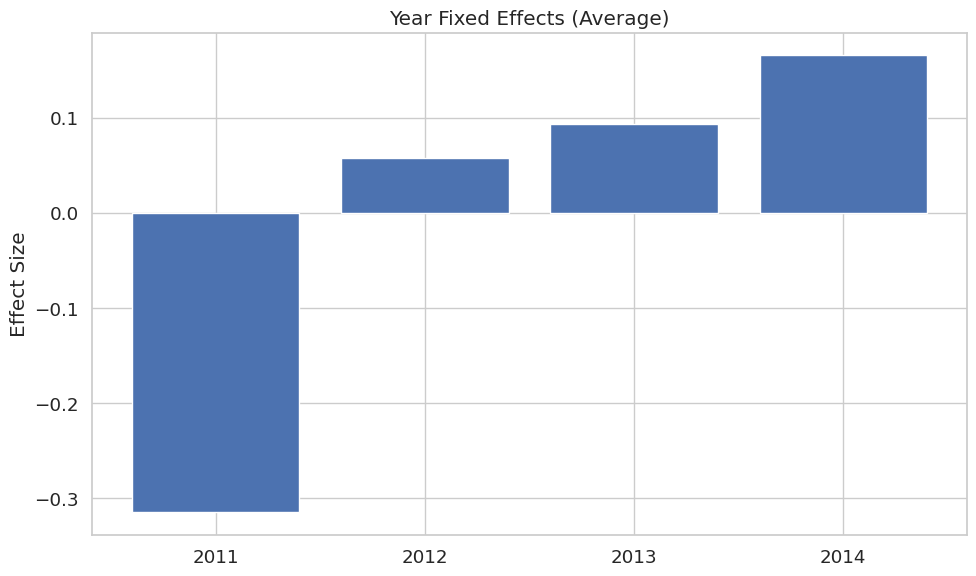

In [16]:
import pandas as pd  
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt  
from linearmodels.panel import PanelOLS  
import statsmodels.api as sm  

# 准备面板数据 - 确保有ward_code和year双索引  
panel_data = panel_df_reset.set_index(['ward_code', 'year'])  

# 准备模型变量  
y = panel_data['obesity_year6']  
X = panel_data[['facility_education', 'facility_commercial', 'facility_local_authority',   
                'unemployment', 'greenspace_pct', 'ptal']]  
X = sm.add_constant(X)  # 添加常数项  

# 使用更直接的方法创建面板模型  
model_fe = PanelOLS(y, X, entity_effects=True, time_effects=True)  
result_fe = model_fe.fit(cov_type='clustered', cluster_entity=True)  
print(result_fe)  

# 提取时间效应的更简单方法  
# 首先找出时间效应  
year_effects = {}  
if hasattr(result_fe, 'estimated_effects'):  
    effects_df = result_fe.estimated_effects  
    # 通过分组把每年的平均效应计算出来  
    year_effects = effects_df.groupby(level='year').mean()  
    
    plt.figure(figsize=(10, 6))  
    years = year_effects.index.astype(str)  
    plt.bar(years, year_effects['estimated_effects'])  
    plt.title('Year Fixed Effects (Average)')  
    plt.ylabel('Effect Size')  
    plt.tight_layout()  
    plt.show()  

In [17]:
# Define outcome variables for each age group  
age_groups = {  
    'Reception': 'obesity_reception',  # 4-5 years old  
    'Year6': 'obesity_year6'           # 10-11 years old  
}  

results_by_age = {}  

for group_name, outcome_var in age_groups.items():  
    # Drop missing values for dependent variable and independent variables  
    data_age = panel_data.dropna(subset=[outcome_var,   
        'facility_education','facility_commercial','facility_local_authority','unemployment','greenspace_pct','ptal'])  
    y = data_age[outcome_var]  
    X = data_age[['facility_education', 'facility_commercial', 'facility_local_authority',  
                  'unemployment', 'greenspace_pct', 'ptal']]  
    X = sm.add_constant(X)  

    # Fit the fixed effects panel regression  
    model = PanelOLS(y, X, entity_effects=True, time_effects=True)  
    result = model.fit(cov_type='clustered', cluster_entity=True)  
    results_by_age[group_name] = result  

    print(f"\n===== Panel Results for {group_name} group =====")  
    print(result.summary.tables[1])  # Print coefficients  


===== Panel Results for Reception group =====
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
const                        14.242     2.0518     6.9412     0.0000      10.218      18.266
facility_education          -0.0620     0.1456    -0.4260     0.6702     -0.3477      0.2236
facility_commercial          0.0834     0.1963     0.4248     0.6710     -0.3016      0.4683
facility_local_authority    -0.3135     0.3575    -0.8767     0.3808     -1.0147      0.3878
unemployment                 0.0004     0.0008     0.5545     0.5793     -0.0011      0.0020
greenspace_pct              -0.0214     0.0243    -0.8791     0.3795     -0.0691      0.0263
ptal                        -0.8847     0.5338    -1.6573     0.0977     -1.9316      0.1623

===== Panel Results fo

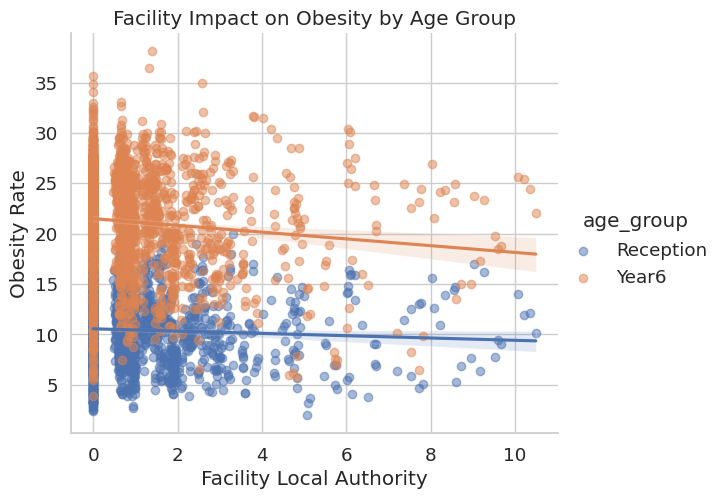

In [18]:
data_age = pd.concat([  
    panel_data[[ 'facility_local_authority', 'obesity_reception']].assign(age_group='Reception'),  
    panel_data[[ 'facility_local_authority', 'obesity_year6']].rename(columns={'obesity_year6':'obesity_reception'}).assign(age_group='Year6')  
])  

# 绘制散点带拟合线  
sns.lmplot(data=data_age, x='facility_local_authority', y='obesity_reception', hue='age_group', aspect=1.2, scatter_kws={'alpha':0.5})  
plt.xlabel("Facility Local Authority")  
plt.ylabel("Obesity Rate")  
plt.title("Facility Impact on Obesity by Age Group")  
plt.show()  

In [19]:
results_by_age_ses = {}  

for group_name, outcome_var in age_groups.items():  
    analysis_data = panel_data.dropna(subset=[  
        outcome_var, 'facility_education', 'facility_commercial', 'facility_local_authority',  
        'unemployment', 'greenspace_pct', 'ptal'  
    ]).copy()  
    
    analysis_data['high_ses'] = (analysis_data['unemployment'] < analysis_data['unemployment'].median()).astype(int)  
    analysis_data['edu_x_ses'] = analysis_data['facility_education'] * analysis_data['high_ses']  
    analysis_data['com_x_ses'] = analysis_data['facility_commercial'] * analysis_data['high_ses']  
    analysis_data['local_x_ses'] = analysis_data['facility_local_authority'] * analysis_data['high_ses']  

    y = analysis_data[outcome_var]  
    X = analysis_data[['facility_education', 'facility_commercial', 'facility_local_authority',  
                       'unemployment', 'greenspace_pct', 'ptal',  
                       'edu_x_ses', 'com_x_ses', 'local_x_ses']]  
    X = sm.add_constant(X)  

    model = PanelOLS(y, X, entity_effects=True, time_effects=True)  
    result = model.fit(cov_type='clustered', cluster_entity=True)  
    results_by_age_ses[group_name] = result  

    print(f"\n===== SES Interaction Panel Results for {group_name} group =====")  
    print(result.summary.tables[1])  # Print coefficients table  


===== SES Interaction Panel Results for Reception group =====
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
const                        13.984     2.0549     6.8054     0.0000      9.9537      18.014
facility_education          -0.0632     0.1455    -0.4341     0.6643     -0.3485      0.2222
facility_commercial          0.1040     0.2005     0.5186     0.6041     -0.2893      0.4972
facility_local_authority    -0.3305     0.3902    -0.8471     0.3971     -1.0959      0.4348
unemployment                 0.0005     0.0008     0.6045     0.5456     -0.0011      0.0021
greenspace_pct              -0.0197     0.0243    -0.8092     0.4185     -0.0673      0.0280
ptal                        -0.8701     0.5327    -1.6335     0.1026     -1.9148      0.1747
edu_x_s

# 总 Panel

In [20]:
outcome_var = 'obesity_year6'  

# Prepare the dataset, dropping rows with missing values in variables of interest  
analysis_data = panel_data.dropna(subset=[  
    outcome_var, 'facility_education', 'facility_commercial', 'facility_local_authority',  
    'unemployment', 'greenspace_pct', 'ptal'  
]).copy()  

# Create SES interaction variable: high SES if unemployment below median  
analysis_data['high_ses'] = (analysis_data['unemployment'] < analysis_data['unemployment'].median()).astype(int)  

# Create interaction terms between facilities and SES  
analysis_data['edu_x_ses'] = analysis_data['facility_education'] * analysis_data['high_ses']  
analysis_data['com_x_ses'] = analysis_data['facility_commercial'] * analysis_data['high_ses']  
analysis_data['local_x_ses'] = analysis_data['facility_local_authority'] * analysis_data['high_ses']  

# Define dependent and independent variables  
y = analysis_data[outcome_var]  
X = analysis_data[['facility_education', 'facility_commercial', 'facility_local_authority',  
                   'unemployment', 'greenspace_pct', 'ptal',  
                   'edu_x_ses', 'com_x_ses', 'local_x_ses']]  

# Add constant term to regressors  
X = sm.add_constant(X)  

# Build panel model with entity and time fixed effects  
model = PanelOLS(y, X, entity_effects=True, time_effects=True)  
result = model.fit(cov_type='clustered', cluster_entity=True)  

# Print model summary  
print(result.summary)  

                          PanelOLS Estimation Summary                           
Dep. Variable:          obesity_year6   R-squared:                        0.0089
Estimator:                   PanelOLS   R-squared (Between):             -0.2217
No. Observations:                2262   R-squared (Within):               0.0194
Date:                Mon, Apr 28 2025   R-squared (Overall):             -0.1963
Time:                        23:09:02   Log-likelihood                   -4274.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.6708
Entities:                         567   P-value                           0.0909
Avg Obs:                       3.9894   Distribution:                  F(9,1683)
Min Obs:                       3.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             1.9258
                            

<Figure size 1200x1000 with 0 Axes>

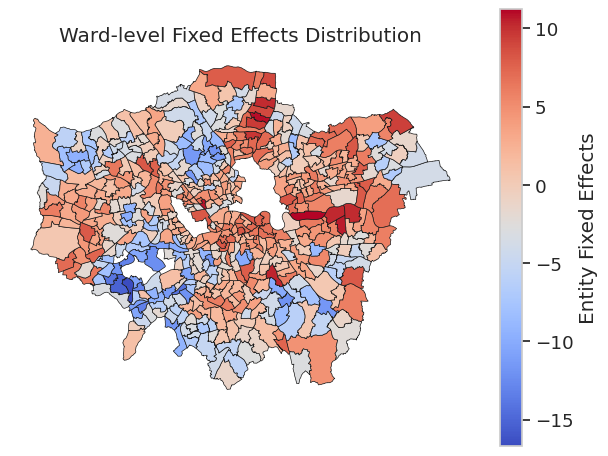

<Figure size 1000x600 with 0 Axes>

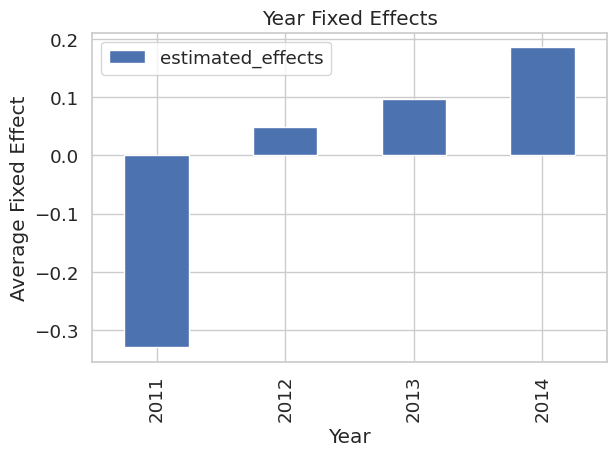

In [28]:
# 1. Ward-level Fixed Effects Map  
entity_effects = result.estimated_effects  

# Reset index to convert MultiIndex to columns  
entity_effects_df = entity_effects.reset_index()  

# Group by ward_code and average estimated effects (entity fixed effects)  
entity_effects_grouped = entity_effects_df.groupby('ward_code')['estimated_effects'].mean().reset_index()  

# Create DataFrame for merging with geometries  
wards_fe_df = pd.DataFrame({  
    'ward_code': entity_effects_grouped['ward_code'],  
    'entity_fe': entity_effects_grouped['estimated_effects']  
})  

wards_gem = wards[['GSS_CODE', 'geometry']] 
wards_gem = wards_gem.rename(columns={'GSS_CODE': 'ward_code'}) 

# Merge geometry with fixed effects data  
wards_fe_gdf = wards_gem.merge(  
    wards_fe_df,  
    left_on='ward_code',  
    right_on='ward_code'  
)  

plt.figure(figsize=(12, 10))  
wards_fe_gdf.plot(  
    column='entity_fe',  
    cmap='coolwarm',  
    linewidth=0.5,  
    edgecolor='k',  
    legend=True,  
    legend_kwds={'label': 'Entity Fixed Effects'}  
)  
plt.title('Ward-level Fixed Effects Distribution')  
plt.axis('off')  
plt.tight_layout()  
plt.show()  

# 2. Year Fixed Effects Bar Chart  
time_effects = result.estimated_effects.groupby(level='year').mean()  

plt.figure(figsize=(10, 6))  
time_effects.plot(kind='bar')  
plt.title('Year Fixed Effects')  
plt.xlabel('Year')  
plt.ylabel('Average Fixed Effect')  
plt.tight_layout()  
plt.show()  

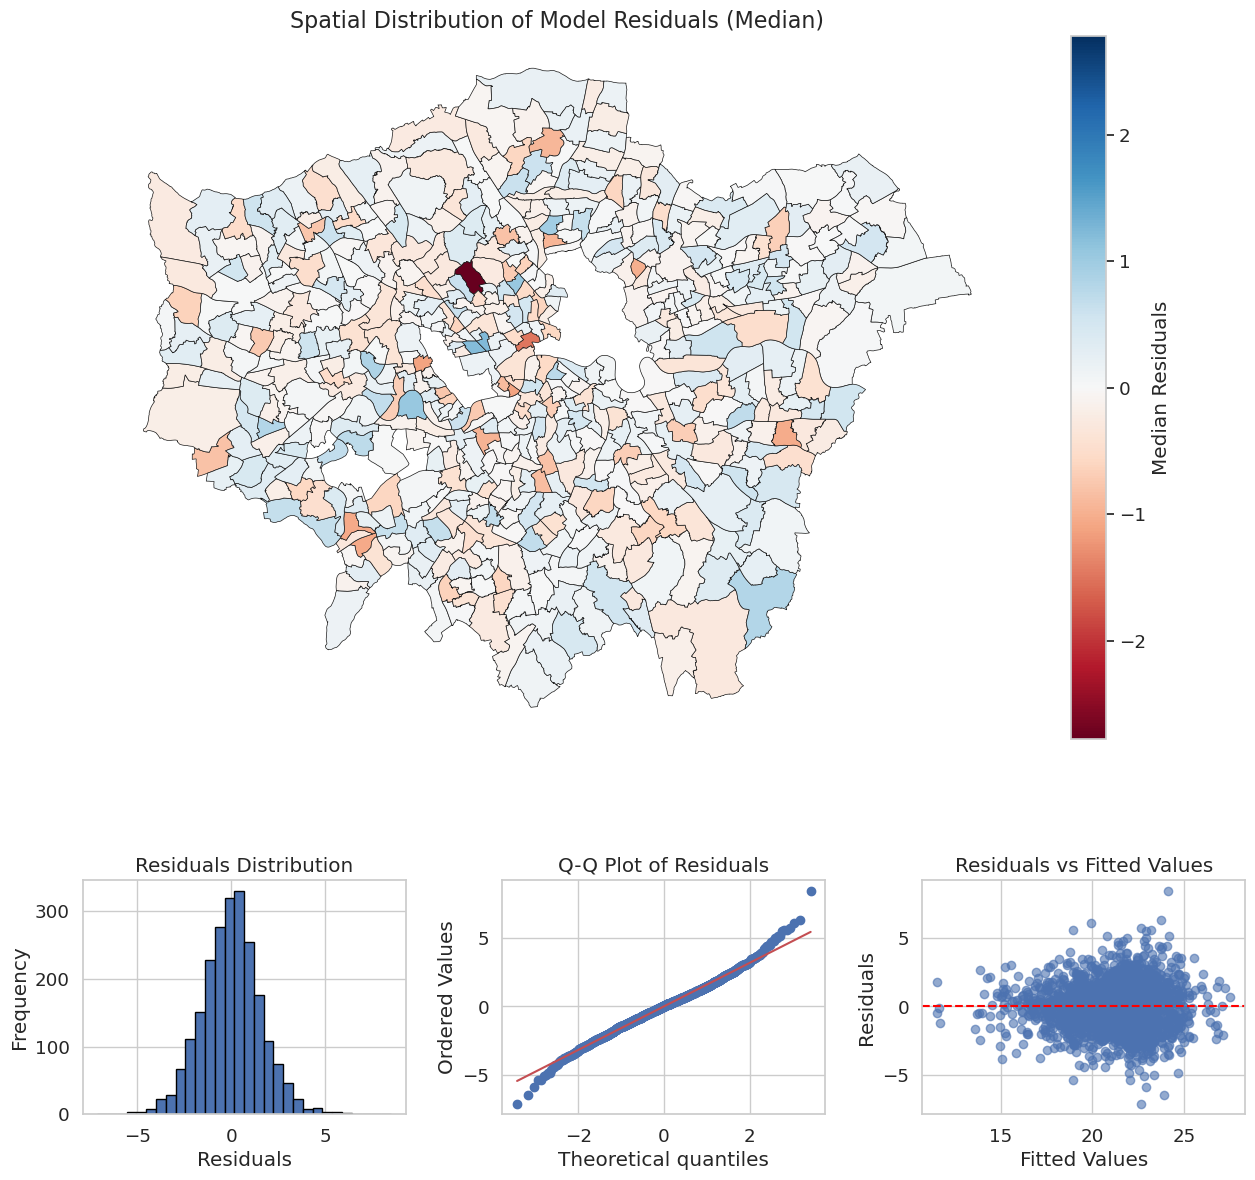

Residuals Summary Statistics:
Mean: 0.000000
Standard Deviation: 1.601267
Skewness: 0.087161
Kurtosis: 1.142507


In [32]:
import numpy as np  
import matplotlib.pyplot as plt  
import scipy.stats as stats  
from matplotlib.gridspec import GridSpec  

# Calculate median residuals by ward for spatial plot  
residuals = result.resids  
median_residuals = residuals.groupby(level='ward_code').median()  

wards_resid_df = pd.DataFrame({  
    'ward_code': median_residuals.index,  
    'median_residual': median_residuals.values  
})  

wards_resid_gdf = wards_gem.merge(  
    wards_resid_df,  
    left_on='ward_code',  
    right_on='ward_code'  
)  

# Determine symmetric vmax for color mapping  
vmax = max(abs(wards_resid_gdf['median_residual'].min()), wards_resid_gdf['median_residual'].max())  
if vmax < 1e-6:  
    vmax = 1e-6  # Set lower bound threshold for visualization  

# Use GridSpec to control height ratios: map is taller, bottom row shorter  
fig = plt.figure(figsize=(15, 14))  
gs = GridSpec(2, 3, height_ratios=[3, 1], hspace=0.3, wspace=0.3)  

# Spatial residuals map (top, spans all columns)  
ax_map = fig.add_subplot(gs[0, :])  
wards_resid_gdf.plot(  
    column='median_residual',  
    cmap='RdBu',  
    linewidth=0.5,  
    edgecolor='k',  
    legend=True,  
    legend_kwds={'label': 'Median Residuals'},  
    vmin=-vmax,  
    vmax=vmax,  
    ax=ax_map  
)  
ax_map.set_title('Spatial Distribution of Model Residuals (Median)', fontsize=16)  
ax_map.axis('off')  
ax_map.set_aspect('equal')  

# Residual diagnostics plots - three smaller plots in bottom row  
ax_hist = fig.add_subplot(gs[1, 0])  
ax_qq = fig.add_subplot(gs[1, 1])  
ax_scatter = fig.add_subplot(gs[1, 2])  

# 1. Histogram of residuals  
ax_hist.hist(residuals, bins=30, edgecolor='black')  
ax_hist.set_title('Residuals Distribution')  
ax_hist.set_xlabel('Residuals')  
ax_hist.set_ylabel('Frequency')  

# 2. Q-Q plot of residuals  
stats.probplot(residuals, plot=ax_qq)  
ax_qq.set_title('Q-Q Plot of Residuals')  

# 3. Residuals vs fitted values scatter plot  
ax_scatter.scatter(result.fitted_values, residuals, alpha=0.6)  
ax_scatter.axhline(y=0, color='red', linestyle='--')  
ax_scatter.set_title('Residuals vs Fitted Values')  
ax_scatter.set_xlabel('Fitted Values')  
ax_scatter.set_ylabel('Residuals')  

plt.show()  

# Print summary statistics of residuals  
print("Residuals Summary Statistics:")  
print(f"Mean: {np.mean(residuals):.6f}")  
print(f"Standard Deviation: {np.std(residuals):.6f}")  
print(f"Skewness: {stats.skew(residuals):.6f}")  
print(f"Kurtosis: {stats.kurtosis(residuals):.6f}")  

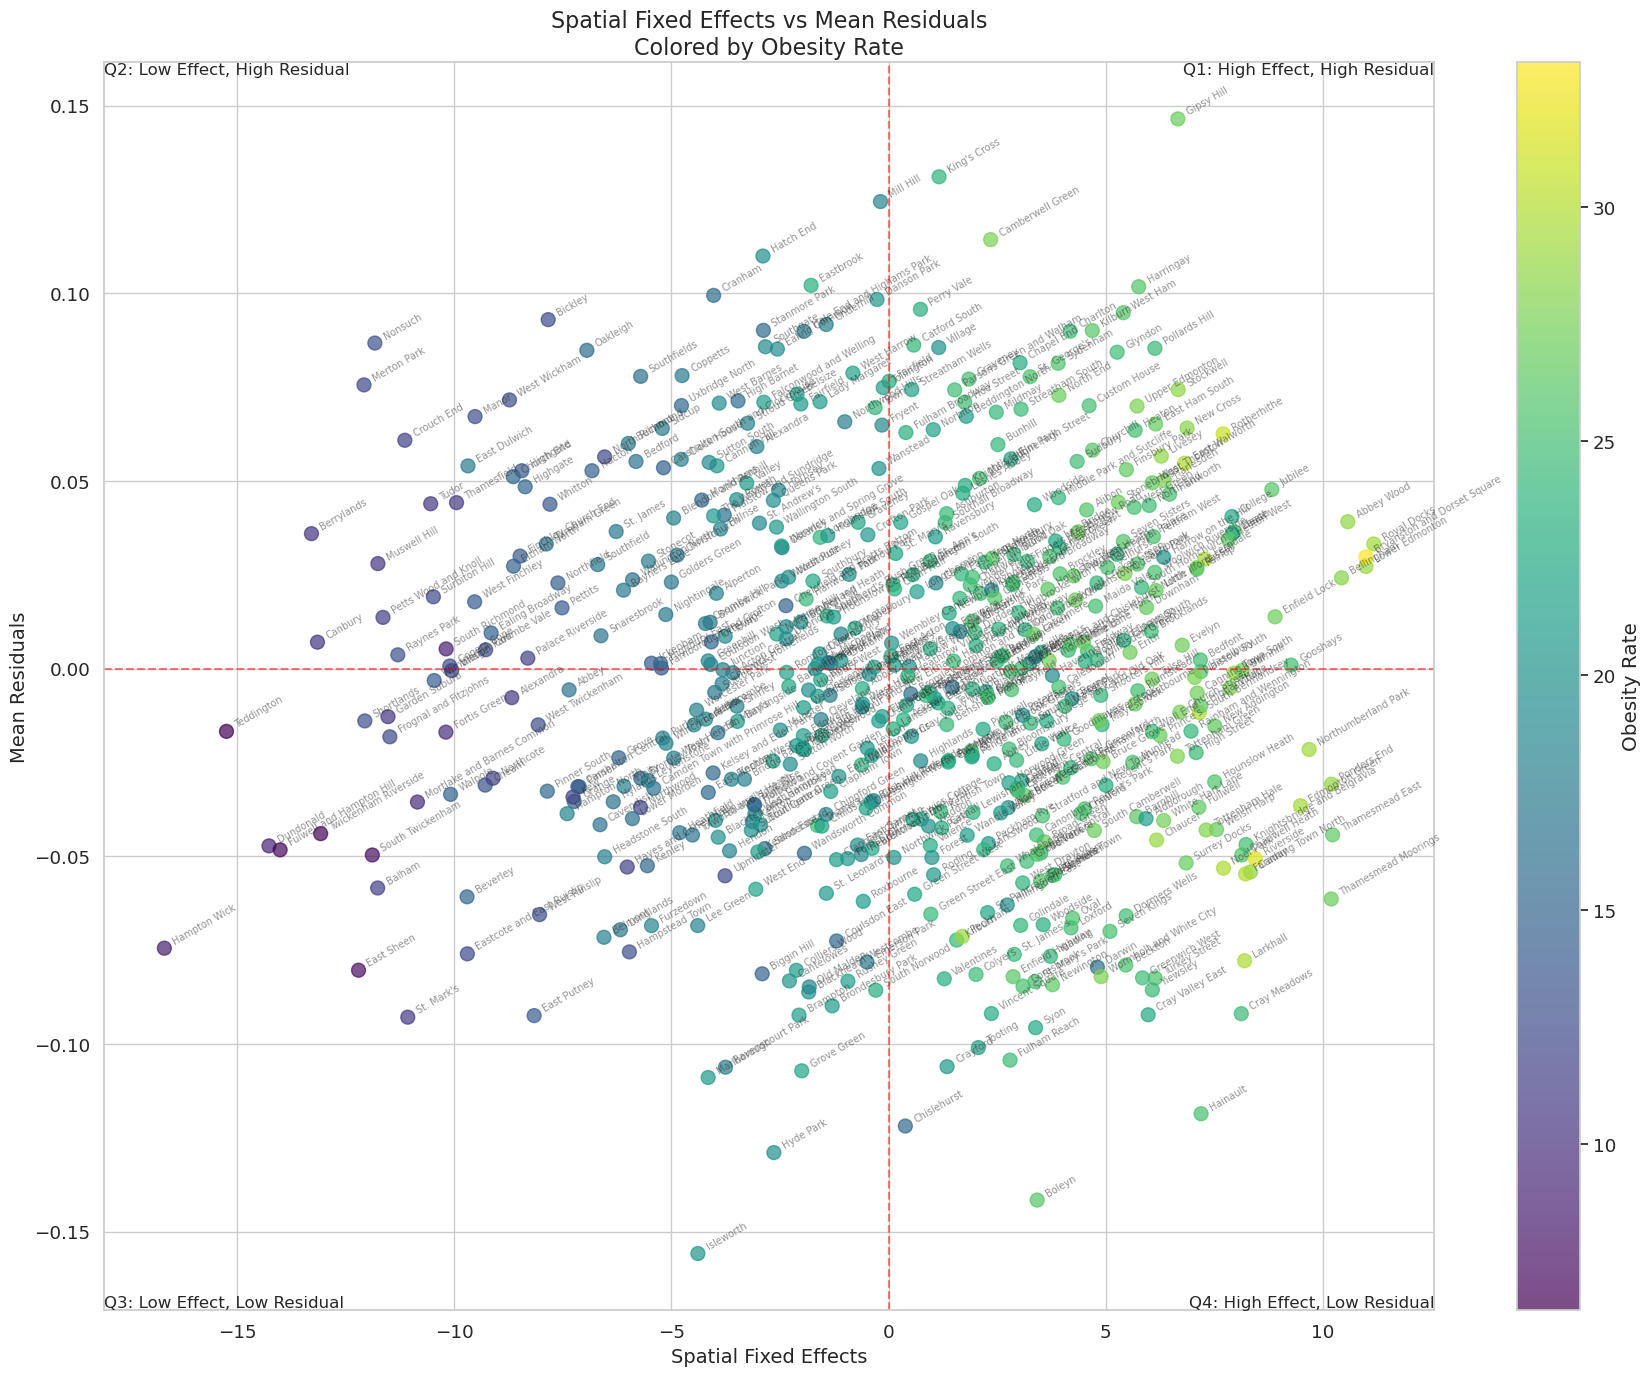

Quadrant Summary:
                                Ward Count  obesity_rate  spatial_effects  \
quadrant                                                                    
Q1: High Effect, High Residual         193     24.683890         4.167067   
Q2: Low Effect, High Residual          200     17.714917        -4.191174   
Q3: Low Effect, Low Residual            83     17.546175        -4.588154   
Q4: High Effect, Low Residual           91     24.910027         4.536959   

                                mean_residuals  
quadrant                                        
Q1: High Effect, High Residual    1.533373e-14  
Q2: Low Effect, High Residual     1.534920e-14  
Q3: Low Effect, Low Residual      1.283222e-14  
Q4: High Effect, Low Residual     1.288672e-14  


In [42]:
# Aggregate spatial fixed effects by ward_code  
spatial_effects = result.estimated_effects.groupby(level='ward_code').mean().squeeze()  

# Aggregate mean residuals by ward_code  
mean_residuals = result.resids.groupby(level='ward_code').mean().squeeze()  

# Calculate mean obesity rate for wards  
obesity_rates = panel_data.groupby('ward_code')['obesity_year6'].mean()  

# Get ward names, use first occurrence for each ward_code  
ward_names = panel_data.groupby('ward_code')['ward_name'].first()  

# Prepare dataframe, aligning indices  
plot_df = pd.DataFrame({  
    'ward_code': spatial_effects.index,  
    'ward_name': ward_names.reindex(spatial_effects.index),  
    'spatial_effects': spatial_effects.values,  
    'mean_residuals': mean_residuals.values,  
    'obesity_rate': obesity_rates.reindex(spatial_effects.index).values  
})  

# Quadrant classification function  
med_spatial = plot_df['spatial_effects'].median()  
med_residual = plot_df['mean_residuals'].median()  

def assign_quadrant(row):  
    if row['spatial_effects'] >= med_spatial and row['mean_residuals'] >= med_residual:  
        return 'Q1: High Effect, High Residual'  
    elif row['spatial_effects'] < med_spatial and row['mean_residuals'] >= med_residual:  
        return 'Q2: Low Effect, High Residual'  
    elif row['spatial_effects'] < med_spatial and row['mean_residuals'] < med_residual:  
        return 'Q3: Low Effect, Low Residual'  
    else:  
        return 'Q4: High Effect, Low Residual'  

plot_df['quadrant'] = plot_df.apply(assign_quadrant, axis=1)  

plt.figure(figsize=(18, 14))  

# Normalize color by obesity rate  
norm = plt.Normalize(plot_df['obesity_rate'].min(), plot_df['obesity_rate'].max())  
cmap = plt.cm.viridis  

# Scatter plot, add tiny jitter to spread points slightly  
jitter_x = np.random.normal(0, 0.05, size=len(plot_df))  
jitter_y = np.random.normal(0, 0.05, size=len(plot_df))  

x_vals = plot_df['spatial_effects'] + jitter_x  
y_vals = plot_df['mean_residuals'] + jitter_y  

scatter = plt.scatter(  
    x_vals,  
    y_vals,  
    c=plot_df['obesity_rate'],  
    cmap=cmap,  
    norm=norm,  
    s=100,  
    alpha=0.7  
)  

plt.colorbar(scatter, label='Obesity Rate')  

# Draw quadrant lines  
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)  

plt.title('Spatial Fixed Effects vs Mean Residuals\nColored by Obesity Rate', fontsize=16)  
plt.xlabel('Spatial Fixed Effects', fontsize=14)  
plt.ylabel('Mean Residuals', fontsize=14)  

# Quadrant annotations  
plt.text(plt.xlim()[1], plt.ylim()[1], 'Q1: High Effect, High Residual', verticalalignment='top', horizontalalignment='right', fontsize=12)  
plt.text(plt.xlim()[0], plt.ylim()[1], 'Q2: Low Effect, High Residual', verticalalignment='top', horizontalalignment='left', fontsize=12)  
plt.text(plt.xlim()[0], plt.ylim()[0], 'Q3: Low Effect, Low Residual', verticalalignment='bottom', horizontalalignment='left', fontsize=12)  
plt.text(plt.xlim()[1], plt.ylim()[0], 'Q4: High Effect, Low Residual', verticalalignment='bottom', horizontalalignment='right', fontsize=12)  

# Annotate every point with ward_name  
for i, row in plot_df.iterrows():  
    plt.annotate(  
        row['ward_name'],  
        (x_vals[i], y_vals[i]),  
        textcoords='offset points',  
        xytext=(5, 3),         # Slight offset to avoid overlapping the dot  
        fontsize=7,  
        alpha=0.5,  
        rotation=30  
    )  

plt.tight_layout()  
plt.show()  

# Quadrant summary  
quadrant_summary = plot_df.groupby('quadrant').agg({  
    'ward_code': 'count',  
    'obesity_rate': 'mean',  
    'spatial_effects': 'mean',  
    'mean_residuals': 'mean'  
}).rename(columns={'ward_code': 'Ward Count'})  

print("Quadrant Summary:")  
print(quadrant_summary)  

In [52]:
import pandas as pd  
from scipy.stats import chi2_contingency  

# 1. Categorize continuous variables by median or quantiles  
plot_df['obesity_year6_cat'] = pd.qcut(plot_df['obesity_year6'], q=2, labels=['Low', 'High'])  
plot_df['obesity_reception_cat'] = pd.qcut(plot_df['obesity_reception'], q=2, labels=['Low', 'High'])  
plot_df['unemployment_cat'] = pd.qcut(plot_df['unemployment'], q=2, labels=['Low SES', 'High SES'])  

# Categorize spatial_effects and residuals separately into High/Low groups using median  
med_spatial = plot_df['spatial_effects'].median()  
plot_df['spatial_cat'] = plot_df['spatial_effects'].apply(lambda x: 'High Spatial Effect' if x >= med_spatial else 'Low Spatial Effect')  

med_residual = plot_df['mean_residuals'].median()  
plot_df['residual_cat'] = plot_df['mean_residuals'].apply(lambda x: 'High Residual' if x >= med_residual else 'Low Residual')  

# 2. Define simplified chi-square test function showing only essentials  
def chi2_test(cat1, cat2, label1, label2):  
    table = pd.crosstab(cat1, cat2)  
    chi2, p, _, _ = chi2_contingency(table)  
    print(f'{label1} vs {label2} | Chi2 = {chi2:.3f}, p = {p:.4f}')  

# 3. Conduct Chi-square tests for spatial_effects category vs obesity and SES  
print("Spatial Effects group associations:")  
chi2_test(plot_df['spatial_cat'], plot_df['obesity_year6_cat'], 'Spatial Effect', 'Obesity Age 6')  
chi2_test(plot_df['spatial_cat'], plot_df['obesity_reception_cat'], 'Spatial Effect', 'Obesity Reception')  
chi2_test(plot_df['spatial_cat'], plot_df['unemployment_cat'], 'Spatial Effect', 'SES')  

print("\nResidual group associations:")  
# 4. Residual category vs obesity and SES overall  
chi2_test(plot_df['residual_cat'], plot_df['obesity_year6_cat'], 'Residual', 'Obesity Age 6')  
chi2_test(plot_df['residual_cat'], plot_df['obesity_reception_cat'], 'Residual', 'Obesity Reception')  
chi2_test(plot_df['residual_cat'], plot_df['unemployment_cat'], 'Residual', 'SES')  

# 5. Residual vs obesity stratified by SES level  
for ses_level in ['Low SES', 'High SES']:  
    subset = plot_df[plot_df['unemployment_cat'] == ses_level]  
    print(f"\nResidual vs Obesity Age 6 within SES = {ses_level}:")  
    chi2_test(subset['residual_cat'], subset['obesity_year6_cat'], 'Residual', 'Obesity Age 6')  


Spatial Effects group associations:
Spatial Effect vs Obesity Age 6 | Chi2 = 333.735, p = 0.0000
Spatial Effect vs Obesity Reception | Chi2 = 194.629, p = 0.0000
Spatial Effect vs SES | Chi2 = 170.587, p = 0.0000

Residual group associations:
Residual vs Obesity Age 6 | Chi2 = 2.484, p = 0.1150
Residual vs Obesity Reception | Chi2 = 0.761, p = 0.3830
Residual vs SES | Chi2 = 0.371, p = 0.5422

Residual vs Obesity Age 6 within SES = Low SES:
Residual vs Obesity Age 6 | Chi2 = 3.920, p = 0.0477

Residual vs Obesity Age 6 within SES = High SES:
Residual vs Obesity Age 6 | Chi2 = 1.885, p = 0.1698


In [44]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  

# ============================  
# Step 1：从原数据合并SES和肥胖率（两个年龄组）  

# 假设你有panel_df（带所有原始数据）和plot_df（空间固定效应与残差聚合）  
# 这里用unemployment均值作为SES代表，按ward_code合并  
ses_df = panel_df.groupby('ward_code')['unemployment'].mean()  

# 两年龄组肥胖率均值  
obesity_reception = panel_df.groupby('ward_code')['obesity_reception'].mean()  
obesity_year6 = panel_df.groupby('ward_code')['obesity_year6'].mean()  

# 把这些合并到plot_df里  
plot_df = plot_df.set_index('ward_code')  
plot_df['unemployment'] = ses_df.reindex(plot_df.index)  
plot_df['obesity_reception'] = obesity_reception.reindex(plot_df.index)  
plot_df['obesity_year6'] = obesity_year6.reindex(plot_df.index)  



/tmp/ipykernel_3368/1881883417.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ses_summary, x='quadrant', y='unemployment', palette='viridis')


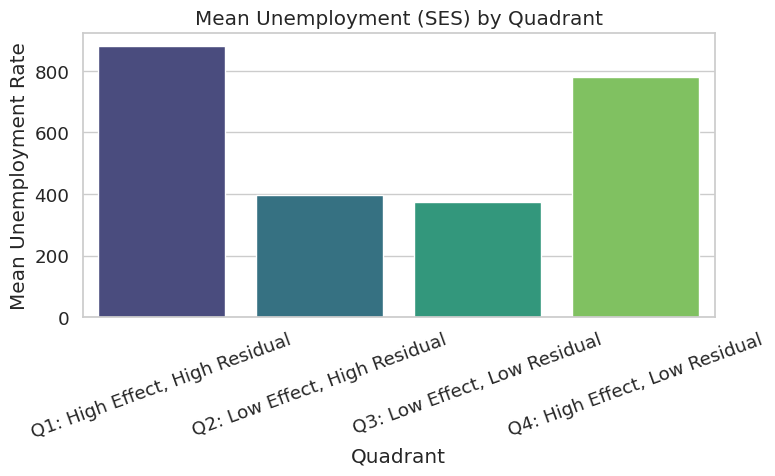

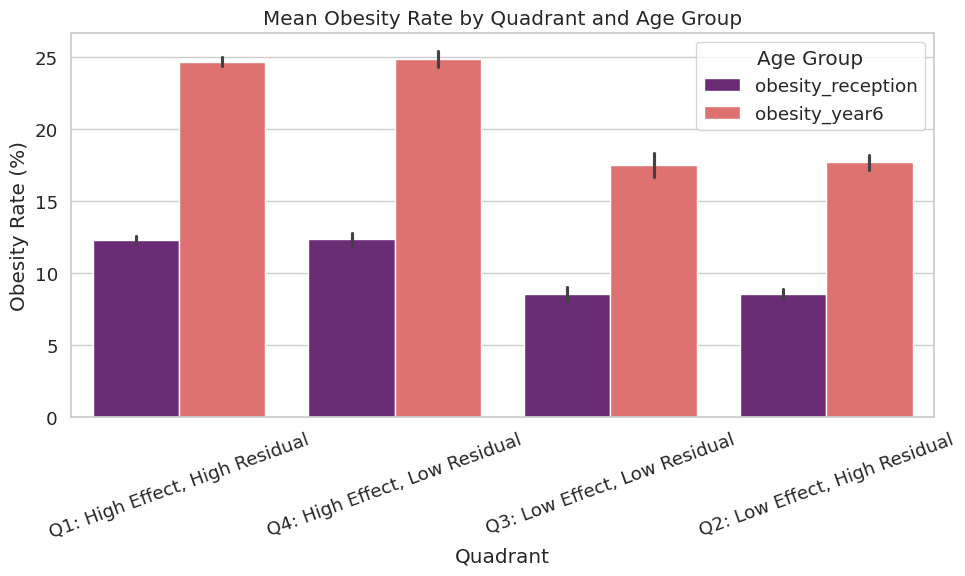

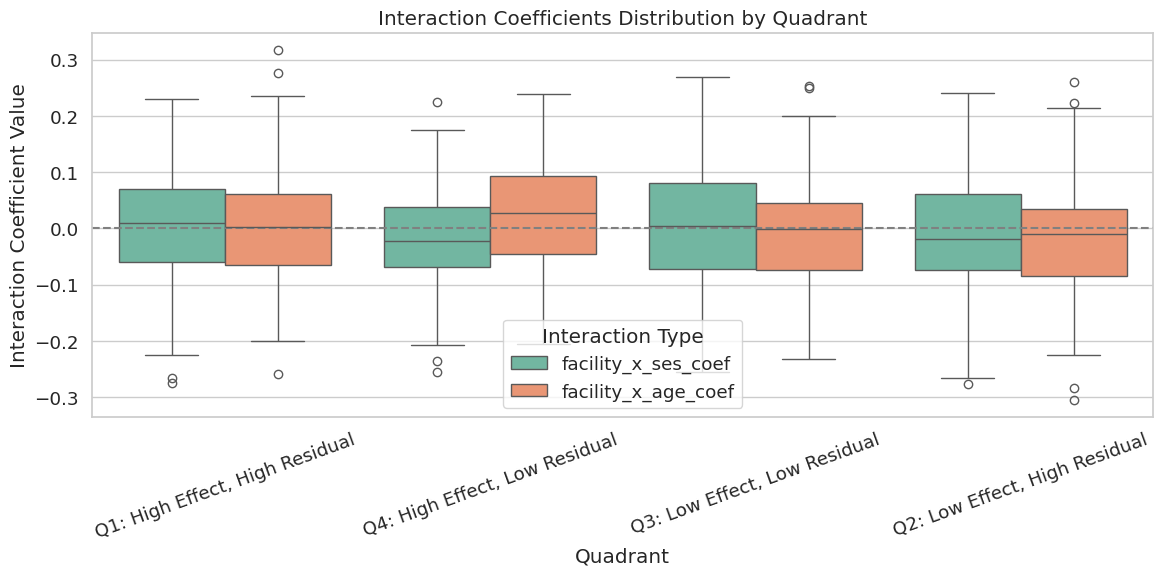

In [45]:
# ============================  
# Step 2：假设你已有交互系数列，示例生成假数据（真实数据请替换）  
n = len(plot_df)  
np.random.seed(0)  
plot_df['facility_x_ses_coef'] = np.random.normal(loc=0, scale=0.1, size=n)  # 模拟值  
plot_df['facility_x_age_coef'] = np.random.normal(loc=0, scale=0.1, size=n)  

# ============================  
# Step 3：绘图 - SES均值柱状图  
ses_summary = plot_df.groupby('quadrant')['unemployment'].mean().reset_index()  

plt.figure(figsize=(8,5))  
sns.barplot(data=ses_summary, x='quadrant', y='unemployment', palette='viridis')  
plt.title('Mean Unemployment (SES) by Quadrant')  
plt.ylabel('Mean Unemployment Rate')  
plt.xlabel('Quadrant')  
plt.xticks(rotation=20)  
plt.tight_layout()  
plt.show()  

# ============================  
# Step 4：绘图 - 两年龄组儿童肥胖率柱状图  
obesity_summary = plot_df.reset_index().melt(  
    id_vars=['ward_name', 'quadrant'],  
    value_vars=['obesity_reception', 'obesity_year6'],  
    var_name='age_group',  
    value_name='obesity_val'  
)  

plt.figure(figsize=(10,6))  
sns.barplot(data=obesity_summary, x='quadrant', y='obesity_val', hue='age_group', palette='magma')  
plt.title('Mean Obesity Rate by Quadrant and Age Group')  
plt.ylabel('Obesity Rate (%)')  
plt.xlabel('Quadrant')  
plt.xticks(rotation=20)  
plt.legend(title='Age Group')  
plt.tight_layout()  
plt.show()  

# ============================  
# Step 5：绘图 - 交互效应箱线图（设施×SES和设施×年龄）  

interaction_df = plot_df.reset_index().melt(  
    id_vars=['quadrant'],  
    value_vars=['facility_x_ses_coef', 'facility_x_age_coef'],  
    var_name='interaction_type',  
    value_name='coef_value'  
)  

plt.figure(figsize=(12,6))  
sns.boxplot(data=interaction_df, x='quadrant', y='coef_value', hue='interaction_type', palette='Set2')  
plt.title('Interaction Coefficients Distribution by Quadrant')  
plt.ylabel('Interaction Coefficient Value')  
plt.xlabel('Quadrant')  
plt.axhline(0, color='gray', linestyle='--')  
plt.xticks(rotation=20)  
plt.legend(title='Interaction Type')  
plt.tight_layout()  
plt.show()  

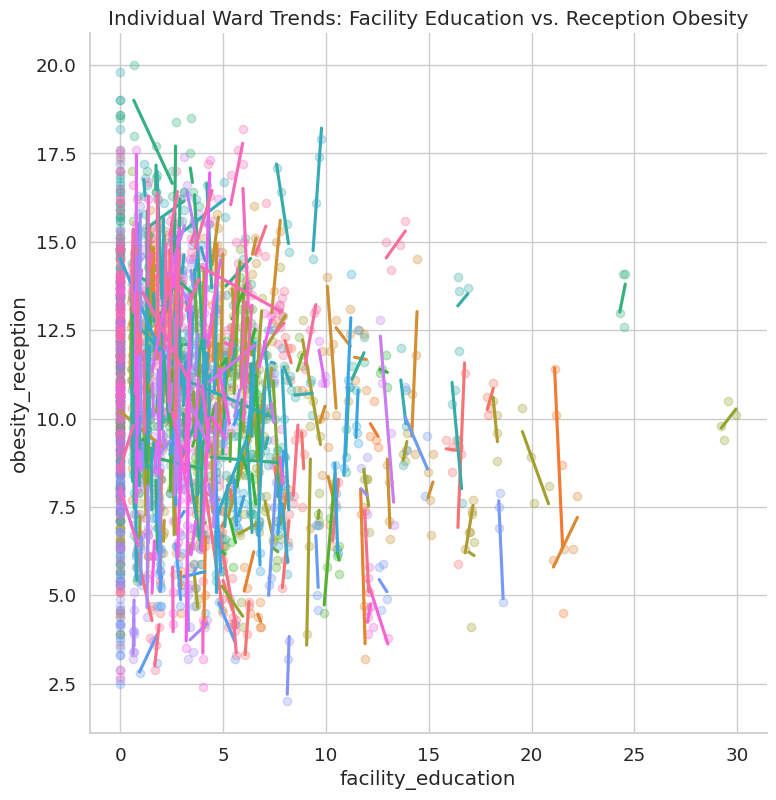

In [142]:
import seaborn as sns  
import matplotlib.pyplot as plt  

# 需要变量都reset_index为普通列  
rec_vis = panel_df.reset_index().dropna(subset=['facility_education', 'obesity_reception'])  

sns.lmplot(data=rec_vis,   
           x='facility_education',   
           y='obesity_reception',   
           hue='ward_code',  # 每一个区一个颜色  
           ci=None,   
           legend=False,   
           scatter_kws={'alpha':.3},  
           height=8,  
           palette='husl')  
plt.title("Individual Ward Trends: Facility Education vs. Reception Obesity")  
plt.show()  